# Loan Approval Prediction - Model Development

### Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler


### Step 2: Import Cleaned Loan Dataset

In [2]:
df = pd.read_csv(r'prosperLoanDataCleaned.csv')
df.head()

,Term,MonthsOfEmployementExperience,IsHomeowner,OpenCreditLines,TotalInquiries,AvailableBankcardCredit,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,LoanNumber,LoanAmount,MonthlyInstallment,InterestRate,IsEmployed,AverageCreditScore,AnyDelinquencies,GoodLoan
0,36,2.000000,1,4.000000,3,1500.000000,0.17,1,3083.333333,19141,9425,330.43,0.1580,1,650,1,1
1,36,96.071582,0,9.260164,1,11210.225447,0.06,1,2083.333333,6466,3001,123.32,0.2750,1,490,1,1
2,36,19.000000,0,2.000000,5,2580.000000,0.27,1,1666.666667,20907,1000,33.81,0.1325,1,650,1,1
3,36,1.000000,0,7.000000,4,3626.000000,0.18,1,2416.666667,125045,4000,137.39,0.1435,1,690,0,0
4,36,121.000000,1,9.000000,1,178.000000,0.49,1,5500.000000,63982,4000,173.71,0.3177,1,710,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55106 entries, 0 to 55105
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Term                           55106 non-null  int64  
 1   MonthsOfEmployementExperience  55106 non-null  float64
 2   IsHomeowner                    55106 non-null  int64  
 3   OpenCreditLines                55106 non-null  float64
 4   TotalInquiries                 55106 non-null  int64  
 5   AvailableBankcardCredit        55106 non-null  float64
 6   DebtToIncomeRatio              55106 non-null  float64
 7   IncomeVerifiable               55106 non-null  int64  
 8   StatedMonthlyIncome            55106 non-null  float64
 9   LoanNumber                     55106 non-null  int64  
 10  LoanAmount                     55106 non-null  int64  
 11  MonthlyInstallment             55106 non-null  float64
 12  InterestRate                   55106 non-null 

### Step 3: Data Pre-processing

In [4]:
df = df.drop(['LoanNumber'], axis=1)
categorical = ['Term','IsHomeowner','IsEmployed','AnyDelinquencies','IncomeVerifiable']
numerical = ['LoanAmount','InterestRate','MonthlyInstallment','MonthsOfEmployementExperience','AverageCreditScore'
             ,'OpenCreditLines','TotalInquiries','AvailableBankcardCredit','DebtToIncomeRatio','StatedMonthlyIncome']

#### Handling Outliers

In [5]:
df[numerical].skew()

LoanAmount                        1.646822
InterestRate                      0.115913
MonthlyInstallment                1.953124
MonthsOfEmployementExperience     1.834853
AverageCreditScore               -1.351894
OpenCreditLines                   1.131160
TotalInquiries                    6.574083
AvailableBankcardCredit           7.593415
DebtToIncomeRatio                12.416432
StatedMonthlyIncome              44.534218
dtype: float64

In [6]:
Q1 = df[numerical].quantile(0.25)
Q3 = df[numerical].quantile(0.75)
IQR = Q3 - Q1

# Calculate median
median = df[numerical].median()

# Identify outliers
outliers_lower = (df[numerical] < (Q1 - 1.5 * IQR))
outliers_upper = (df[numerical] > (Q3 + 1.5 * IQR))

# Replace outliers with median
df[numerical] = df[numerical].mask(outliers_lower, median, axis=1)
df[numerical] = df[numerical].mask(outliers_upper, median, axis=1)

In [7]:
df[numerical].skew()

LoanAmount                       1.106712
InterestRate                     0.115913
MonthlyInstallment               0.980513
MonthsOfEmployementExperience    0.856838
AverageCreditScore              -0.158725
OpenCreditLines                  0.453486
TotalInquiries                   1.077752
AvailableBankcardCredit          1.292952
DebtToIncomeRatio                0.428901
StatedMonthlyIncome              0.591492
dtype: float64

### Step 4: Prepare Data for Model Training

#### Shuffle the Rows of a DataFrame 

In [8]:
df = df.sample(frac=1, random_state=42)
df

,Term,MonthsOfEmployementExperience,IsHomeowner,OpenCreditLines,TotalInquiries,AvailableBankcardCredit,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,LoanAmount,MonthlyInstallment,InterestRate,IsEmployed,AverageCreditScore,AnyDelinquencies,GoodLoan
2098,36,60.000000,1,8.000000,5,362.000000,0.480000,1,9207.583333,2000,0.00,0.2998,1,670,0,1
43905,36,9.000000,0,5.000000,9,0.000000,0.510000,1,833.333333,1000,45.24,0.3500,1,630,0,0
46310,36,96.071582,0,9.260164,1,11210.225447,0.170000,1,899.666667,4500,188.58,0.2900,1,690,1,0
53388,36,63.000000,1,6.000000,5,1913.000000,0.380000,1,3208.333333,4000,163.56,0.2712,1,610,0,0
32128,36,11.000000,1,9.000000,8,138.000000,0.275947,0,0.000000,3000,108.13,0.1778,1,550,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,36,49.000000,1,4.000000,5,7046.000000,0.275947,0,0.000000,10000,348.91,0.1546,1,770,0,0
54343,36,22.000000,0,2.000000,6,0.000000,0.275947,0,1283.333333,1500,60.44,0.2600,1,670,1,1
38158,36,87.000000,0,6.000000,13,491.000000,0.200000,1,4372.750000,4000,159.46,0.2520,1,610,1,0
860,36,18.000000,1,8.000000,14,7252.000000,0.180000,1,3433.666667,6000,203.61,0.1350,1,750,1,1


####  Separate the Input Features (X) from the Target Variable (y).

In [9]:
X = df.drop(columns=['GoodLoan']) 
y = df['GoodLoan']  

####  Standardize Numerical Features using Feature Scaling. 

In [10]:
Standard_Scaler = StandardScaler()
X[numerical] = Standard_Scaler.fit_transform(X[numerical])

print("Scaled Features (x):")
print(X.head())

print("\nTarget Variable (y):")
print(y.head())

Scaled Features (x):
       Term  MonthsOfEmployementExperience  IsHomeowner  OpenCreditLines  \
2098     36                      -0.124567            1        -0.023026   
43905    36                      -1.124880            0        -0.762092   
46310    36                       0.582939            0         0.287422   
53388    36                      -0.065725            1        -0.515737   
32128    36                      -1.085652            1         0.223329   

       TotalInquiries  AvailableBankcardCredit  DebtToIncomeRatio  \
2098        -0.114880                -0.875305           2.405529   
43905        0.820833                -0.934278           2.680542   
46310       -1.050592                 0.891976          -0.436274   
53388       -0.114880                -0.622632           1.488818   
32128        0.586905                -0.911796           0.534950   

       IncomeVerifiable  StatedMonthlyIncome  LoanAmount  MonthlyInstallment  \
2098                  1    

#### Split the Data into Train Test and Validation Sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### Perform Feature Selection 

In [12]:
# Instantiate SelectKBest with ANOVA F-value as the score function
k_best_selector = SelectKBest(score_func=f_classif, k=12)  # Select top 12 features

# Fit SelectKBest to training data
X_train_selected = k_best_selector.fit_transform(X_train, y_train)

# Print the names of the selected features
selected_feature_indices = k_best_selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]
print("Selected Features:")
for feature in selected_feature_names:
    print(feature)
    
X_train = X_train[selected_feature_names]
X_val = X_val[selected_feature_names]
X_test = X_test[selected_feature_names]

Selected Features:
Term
IsHomeowner
OpenCreditLines
TotalInquiries
AvailableBankcardCredit
DebtToIncomeRatio
IncomeVerifiable
StatedMonthlyIncome
MonthlyInstallment
InterestRate
AverageCreditScore
AnyDelinquencies


### Step 6: Model Building

#### Subset Selection

In [13]:
def forward_stepwise_selection(model, X_train, X_test, y_train, y_test):
    remaining_features = list(X_train.columns)
    selected_features = []
    prev_score = 0
    while True:
        best_score = 0
        for feature in remaining_features:
            model.fit(X_train[selected_features + [feature]], y_train)
            y_pred = model.predict(X_test[selected_features + [feature]])
            #score = f1_score(y_test, y_pred, average='weighted')
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            score = auc(fpr, tpr)
            #score = accuracy_score(y_test, y_pred)
            if score > best_score:
                best_score = score
                best_feature = feature
        if best_score > prev_score:
            prev_score = best_score
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
    return selected_features

### Logistic Regression


Selected Features: ['InterestRate', 'Term', 'TotalInquiries', 'StatedMonthlyIncome', 'AnyDelinquencies', 'DebtToIncomeRatio', 'IsHomeowner', 'AverageCreditScore', 'MonthlyInstallment', 'IncomeVerifiable']

Best Parameters: {'C': 1}

Cross-validation scores: [0.57034221 0.57673695 0.57414449 0.57569997 0.57639129]

Validation accuracy: 0.5746629796059454
Training accuracy: 0.5752160387141376
Testing accuracy: 0.577425598838616


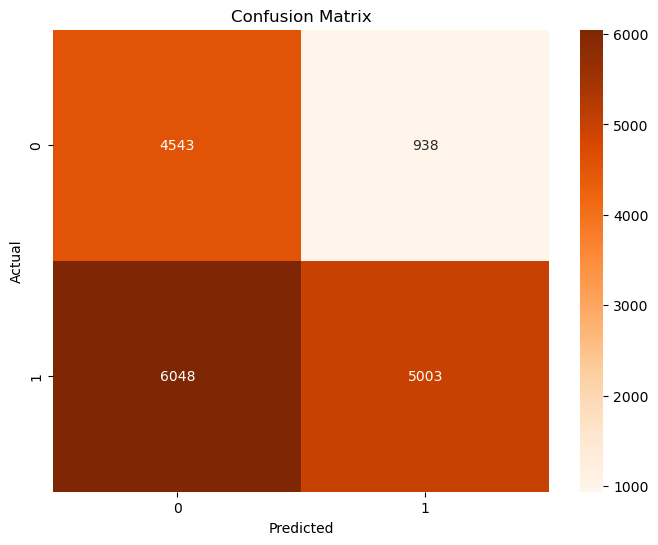

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.83      0.57      5481
           1       0.84      0.45      0.59     11051

    accuracy                           0.58     16532
   macro avg       0.64      0.64      0.58     16532
weighted avg       0.71      0.58      0.58     16532

Precision: 0.7051338751472839
Recall: 0.577425598838616
F1 Score: 0.5810628014428235

The accuracy of the Logistic Regression Model is: 57.74 % .

The ROC-AUC Score of the Logistic Regression Model is: 0.6407912785179315 .


In [14]:
LR = LogisticRegression(max_iter=1000,class_weight={0:3, 1:1}, random_state=42)

# Best Subset Selection
# best_subset_LR = forward_stepwise_selection(LR,X_train, X_val, y_train, y_val)
# print("\nSelected Features:", best_subset_LR)

# Hyper-parameter Tuning
# param_grid = {
#    'C': [0.001, 0.01, 0.1, 1, 10, 100]
# }
# grid_search = GridSearchCV(LR, param_grid, cv=5, scoring='roc_auc')
# grid_search.fit(X_train[best_subset_LR], y_train)
# best_params_LR = grid_search.best_params_ 
# print("\nBest Parameters:", best_params_LR)

best_subset_LR = ['InterestRate', 'Term', 'TotalInquiries', 'StatedMonthlyIncome', 'AnyDelinquencies', 
                'DebtToIncomeRatio', 'IsHomeowner', 'AverageCreditScore', 'MonthlyInstallment', 'IncomeVerifiable']
print("\nSelected Features:", best_subset_LR)
best_params_LR =  {'C': 1}
print("\nBest Parameters:", best_params_LR)

# Model with best parameters
LR = LogisticRegression(**best_params_LR,max_iter=1000,class_weight={0:3, 1:1}, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(LR, X_train[best_subset_LR], y_train, cv=5)

# Print cross-validation scores
print("\nCross-validation scores:", cv_scores)

# Calculate mean validation accuracy
validation_acc_LR = np.mean(cv_scores)
print("\nValidation accuracy:", np.mean(validation_acc_LR))

# Fit the model with selected features
LR.fit(X_train[best_subset_LR], y_train)

# Calculate training accuracy
y_pred = LR.predict(X_train[best_subset_LR])
train_acc_LR = accuracy_score(y_train, y_pred)
print("Training accuracy:", train_acc_LR)

# Calculate testing accuracy
y_pred = LR.predict(X_test[best_subset_LR])
test_acc_LR = accuracy_score(y_test, y_pred)
print("Testing accuracy:", test_acc_LR)

# Calculate precision, recall, and F1 score
precision_LR = precision_score(y_test, y_pred, average='weighted')
recall_LR = recall_score(y_test, y_pred, average='weighted')
f1_LR = f1_score(y_test, y_pred, average='weighted')

# Build a classification report
classification_rep_LR = classification_report(y_test, y_pred)

# Plot a confusion matrix
confusion_matrix_LR = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_LR, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:\n", classification_rep_LR)
print("Precision:", precision_LR)
print("Recall:", recall_LR)
print("F1 Score:", f1_LR)

print("\nThe accuracy of the Logistic Regression Model is:", round(test_acc_LR*100,2),"% .")

fpr_LR, tpr_LR, _ = roc_curve(y_test, y_pred)
auc_LR = auc(fpr_LR, tpr_LR)

print("\nThe ROC-AUC Score of the Logistic Regression Model is:",auc_LR,".")

### Extreme Gradient Boosting (XGBoost)


Selected Features: ['InterestRate', 'MonthlyInstallment', 'AverageCreditScore', 'Term', 'AnyDelinquencies', 'IsHomeowner', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'OpenCreditLines']

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

Cross-validation scores: [0.63480816 0.64379537 0.6389561  0.63878327 0.64362254]

Validation accuracy: 0.6399930867611475
Training accuracy: 0.652886277220878
Testing accuracy: 0.6408782966368255


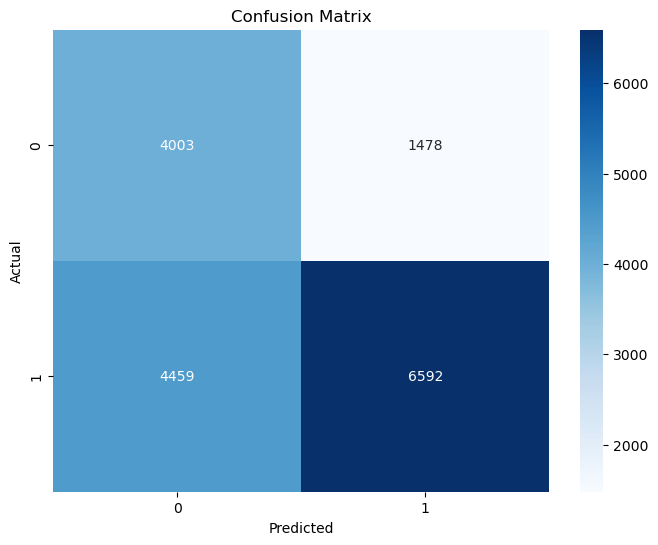

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.73      0.57      5481
           1       0.82      0.60      0.69     11051

    accuracy                           0.64     16532
   macro avg       0.64      0.66      0.63     16532
weighted avg       0.70      0.64      0.65     16532

Precision: 0.7028706412690978
Recall: 0.6408782966368256
F1 Score: 0.6512743583745236

The accuracy of the Extreme Gradient Boosting Model is: 64.09 % .

The ROC-AUC Score of the Extreme Gradient Boosting (XGBoost) is: 0.6634241410232973 .


In [15]:
weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
XGB = XGBClassifier(random_state=42,scale_pos_weight=weight)

# Best Subset Selection
# best_subset_XGB = forward_stepwise_selection(XGB,X_train, X_val, y_train, y_val)

# Hyper-parameter Tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of boosting rounds
#     'learning_rate': [0.05, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
#     'max_depth': [3, 4, 5],  # Maximum depth of a tree, deeper trees can model more complex relationships
# }

# grid_search = GridSearchCV(XGB, param_grid, cv=5, scoring='roc_auc')
# grid_search.fit(X_train[best_subset_XGB], y_train)
# best_params_XGB = grid_search.best_params_ 

# print("\nSelected Features:", best_subset_XGB)
# print("\nBest Parameters:", best_params_XGB)

best_subset_XGB = ['InterestRate', 'MonthlyInstallment', 'AverageCreditScore', 'Term', 'AnyDelinquencies', 
'IsHomeowner', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'OpenCreditLines']
print("\nSelected Features:", best_subset_XGB)

best_params_XGB = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
print("\nBest Parameters:", best_params_XGB)

# Model with best parameters
XGB = XGBClassifier(**best_params_XGB,random_state=42,scale_pos_weight=weight)

# Perform cross-validation
cv_scores = cross_val_score(XGB, X_train[best_subset_XGB], y_train, cv=5)

# Print cross-validation scores
print("\nCross-validation scores:", cv_scores)

# Calculate mean validation accuracy
validation_acc_XGB = np.mean(cv_scores)
print("\nValidation accuracy:", np.mean(validation_acc_XGB))

# Fit the model with selected features
XGB.fit(X_train[best_subset_XGB], y_train)

# Calculate training accuracy
y_pred = XGB.predict(X_train[best_subset_XGB])
train_acc_XGB = accuracy_score(y_train, y_pred)
print("Training accuracy:", train_acc_XGB)

# Calculate testing accuracy
y_pred = XGB.predict(X_test[best_subset_XGB])
test_acc_XGB = accuracy_score(y_test, y_pred)
print("Testing accuracy:", test_acc_XGB)

# Calculate precision, recall, and F1 score
precision_XGB = precision_score(y_test, y_pred, average='weighted')
recall_XGB = recall_score(y_test, y_pred, average='weighted')
f1_XGB = f1_score(y_test, y_pred, average='weighted')

# Build a classification report
classification_rep_XGB = classification_report(y_test, y_pred)

# Plot a confusion matrix
confusion_matrix_XGB = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_XGB, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:\n", classification_rep_XGB)
print("Precision:", precision_XGB)
print("Recall:", recall_XGB)
print("F1 Score:", f1_XGB)

print("\nThe accuracy of the Extreme Gradient Boosting Model is:", round(test_acc_XGB*100,2),"% .")

fpr_XGB, tpr_XGB, _ = roc_curve(y_test, y_pred)
auc_XGB = auc(fpr_XGB, tpr_XGB)

print("\nThe ROC-AUC Score of the Extreme Gradient Boosting (XGBoost) is:",auc_XGB,".")

#### Under Sampling the Dataset to handle the Imbalance in Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

### K - Nearest Neighbour (KNN)


Selected Features: ['MonthlyInstallment', 'LoanAmount', 'Term', 'AverageCreditScore', 'AnyDelinquencies', 'InterestRate']

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

Cross-validation scores: [0.61836969 0.63467279 0.62962113 0.61859931 0.63206247]

Validation accuracy: 0.6266650774958114
Training accuracy: 0.6920180031229908
Testing accuracy: 0.6130466340047178


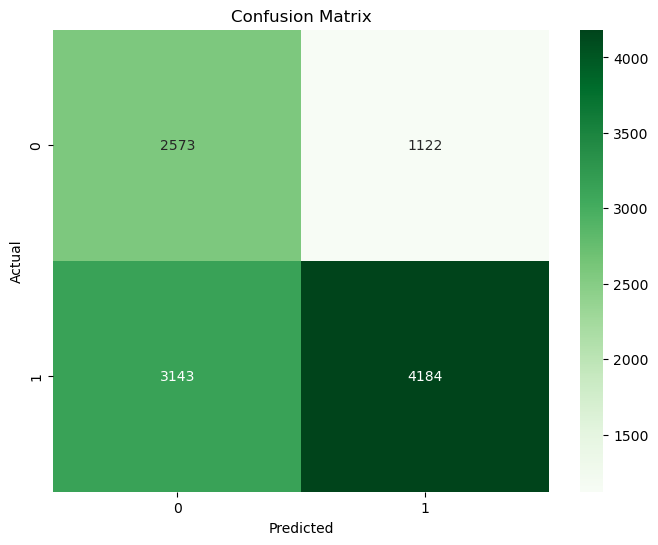

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.70      0.55      3695
           1       0.79      0.57      0.66      7327

    accuracy                           0.61     11022
   macro avg       0.62      0.63      0.60     11022
weighted avg       0.68      0.61      0.62     11022

Precision: 0.6750960859798549
Recall: 0.6130466340047178
F1 Score: 0.6236435188070928

The accuracy of the K - Nearest Neighbour Model is: 61.3 % .

The ROC-AUC Score of the K - Nearest Neighbour Model is: 0.6336925191697419 .


In [17]:
KNN = KNeighborsClassifier()

# Best Subset Selection
# best_subset_KNN = forward_stepwise_selection(KNN,X_train, X_val, y_train, y_val)
# print("\nSelected Features:", best_subset_KNN)

# Hyper-parameter Tuning
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11],  # Different values of k
#     'weights': ['uniform', 'distance'],  # Weighting scheme
#     'metric': ['euclidean', 'manhattan']  # Distance metric
# }
# grid_search = GridSearchCV(KNN, param_grid, cv=5, scoring='roc_auc')
# grid_search.fit(X_train[best_subset_KNN], y_train)
# best_params_KNN = grid_search.best_params_ 
# print("\nBest Parameters:", best_params_KNN)

best_subset_KNN = ['MonthlyInstallment', 'LoanAmount', 'Term', 'AverageCreditScore', 'AnyDelinquencies', 'InterestRate']
print("\nSelected Features:", best_subset_KNN)
best_params_KNN = {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
print("\nBest Parameters:", best_params_KNN)

# Model with best parameters
KNN = KNeighborsClassifier(**best_params_KNN)

# Perform cross-validation
cv_scores = cross_val_score(KNN, X_train[best_subset_KNN], y_train, cv=5)

# Print cross-validation scores
print("\nCross-validation scores:", cv_scores)

# Calculate mean validation accuracy
validation_acc_KNN = np.mean(cv_scores)
print("\nValidation accuracy:", np.mean(validation_acc_KNN))

# Fit the model with selected features
KNN.fit(X_train[best_subset_KNN], y_train)

# Calculate training accuracy
y_pred = KNN.predict(X_train[best_subset_KNN])
train_acc_KNN = accuracy_score(y_train, y_pred)
print("Training accuracy:", train_acc_KNN)

# Calculate testing accuracy
y_pred = KNN.predict(X_test[best_subset_KNN])
test_acc_KNN = accuracy_score(y_test, y_pred)
print("Testing accuracy:", test_acc_KNN)

# Calculate precision, recall, and F1 score
precision_KNN = precision_score(y_test, y_pred, average='weighted')
recall_KNN = recall_score(y_test, y_pred, average='weighted')
f1_KNN = f1_score(y_test, y_pred, average='weighted')

# Build a classification report
classification_rep_KNN = classification_report(y_test, y_pred)

# Plot a confusion matrix
confusion_matrix_KNN = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_KNN, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:\n", classification_rep_KNN)
print("Precision:", precision_KNN)
print("Recall:", recall_KNN)
print("F1 Score:", f1_KNN)

print("\nThe accuracy of the K - Nearest Neighbour Model is:", round(test_acc_KNN*100,2),"% .")

fpr_KNN, tpr_KNN, _ = roc_curve(y_test, y_pred)
auc_KNN = auc(fpr_KNN, tpr_KNN)

print("\nThe ROC-AUC Score of the K - Nearest Neighbour Model is:",auc_KNN,".")

### Multilayer Perceptron (MLP) Classifier


Selected Features: ['InterestRate', 'MonthlyInstallment', 'LoanAmount', 'TotalInquiries', 'StatedMonthlyIncome', 'AnyDelinquencies', 'AverageCreditScore']


C:\Users\parka\anaconda3.1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\parka\anaconda3.1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\parka\anaconda3.1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\parka\anaconda3.1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\parka\anaconda3.1\lib\site-packages\sklearn\neural_


Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}

Cross-validation scores: [0.64707233 0.65487945 0.64225029 0.64913892 0.65502986]

Validation accuracy: 0.6496741689946086
Training accuracy: 0.662579222926426
Testing accuracy: 0.6333696243875885


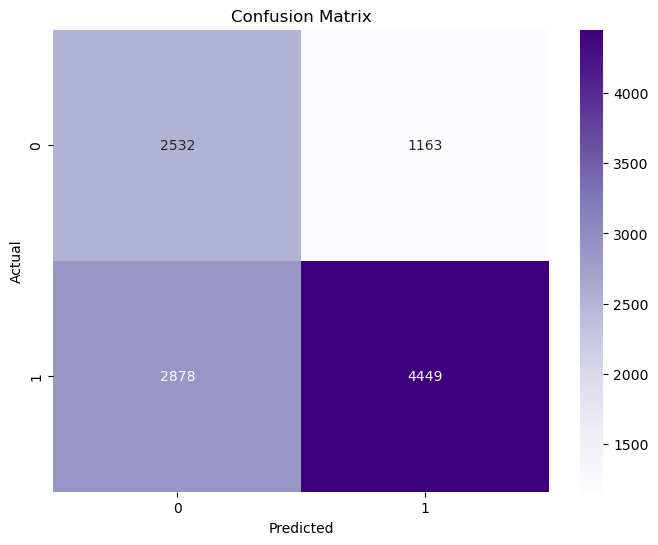

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.69      0.56      3695
           1       0.79      0.61      0.69      7327

    accuracy                           0.63     11022
   macro avg       0.63      0.65      0.62     11022
weighted avg       0.68      0.63      0.64     11022

Precision: 0.6838990016433403
Recall: 0.6333696243875885
F1 Score: 0.6436009997482628

The accuracy of the Multilayer Perceptron (MLP) Classifier Model is: 63.34 % .

The ROC-AUC Score of the Multilayer Perceptron (MLP) Classifier Model is: 0.6462282809258506 .


In [18]:
MLP = MLPClassifier(random_state=42, max_iter=1000)

# Best Subset Selection
# best_subset_MLP = forward_stepwise_selection(MLP,X_train, X_val, y_train, y_val)
best_subset_MLP = ['InterestRate', 'MonthlyInstallment', 'LoanAmount', 'TotalInquiries',
                   'StatedMonthlyIncome', 'AnyDelinquencies', 'AverageCreditScore']
print("\nSelected Features:", best_subset_MLP)


# Hyper-parameter Tuning
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Different architectures for hidden layers
#     'activation': ['relu', 'tanh'],  # Activation functions
#     'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
# }
# grid_search = GridSearchCV(MLP, param_grid, cv=5, scoring='roc_auc')
# grid_search.fit(X_train[best_subset_MLP], y_train)
# best_params_MLP = grid_search.best_params_ 
best_params_MLP = {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
print("\nBest Parameters:", best_params_MLP)

# Model with best parameters
MLP = MLPClassifier(**best_params_MLP,random_state=42, max_iter=1000)

# Perform cross-validation
cv_scores = cross_val_score(MLP, X_train[best_subset_MLP], y_train, cv=5)

# Print cross-validation scores
print("\nCross-validation scores:", cv_scores)

# Calculate mean validation accuracy
validation_acc_MLP = np.mean(cv_scores)
print("\nValidation accuracy:", np.mean(validation_acc_MLP))

# Fit the model with selected features
MLP.fit(X_train[best_subset_MLP], y_train)

# Calculate training accuracy
y_pred = MLP.predict(X_train[best_subset_MLP])
train_acc_MLP = accuracy_score(y_train, y_pred)
print("Training accuracy:", train_acc_MLP)

# Calculate testing accuracy
y_pred = MLP.predict(X_test[best_subset_MLP])
test_acc_MLP = accuracy_score(y_test, y_pred)
print("Testing accuracy:", test_acc_MLP)

# Calculate precision, recall, and F1 score
precision_MLP = precision_score(y_test, y_pred, average='weighted')
recall_MLP = recall_score(y_test, y_pred, average='weighted')
f1_MLP = f1_score(y_test, y_pred, average='weighted')

# Build a classification report
classification_rep_MLP = classification_report(y_test, y_pred)

# Plot a confusion matrix
confusion_matrix_MLP = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_MLP, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:\n", classification_rep_MLP)
print("Precision:", precision_MLP)
print("Recall:", recall_MLP)
print("F1 Score:", f1_MLP)

print("\nThe accuracy of the Multilayer Perceptron (MLP) Classifier Model is:", round(test_acc_MLP*100,2),"% .")

fpr_MLP, tpr_MLP, _ = roc_curve(y_test, y_pred)
auc_MLP = auc(fpr_MLP, tpr_MLP)

print("\nThe ROC-AUC Score of the Multilayer Perceptron (MLP) Classifier Model is:",auc_MLP,".")

### Support Vector Machine (SVM)


Selected Features: ['InterestRate', 'MonthlyInstallment', 'TotalInquiries', 'AvailableBankcardCredit', 'AverageCreditScore', 'StatedMonthlyIncome', 'LoanAmount', 'AnyDelinquencies', 'IsHomeowner', 'IncomeVerifiable']

Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'coef0': 0.0, 'C': 1}

Cross-validation scores: [0.65258324 0.65350172 0.652124   0.64546498 0.64813964]

Validation accuracy: 0.650362715942214
Training accuracy: 0.6634058969413061
Testing accuracy: 0.6199419343131918


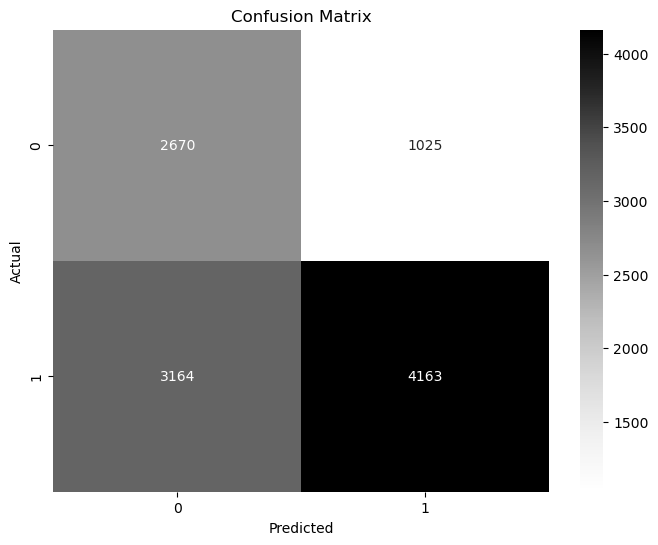

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.72      0.56      3695
           1       0.80      0.57      0.67      7327

    accuracy                           0.62     11022
   macro avg       0.63      0.65      0.61     11022
weighted avg       0.69      0.62      0.63     11022

Precision: 0.6868495709927309
Recall: 0.6199419343131918
F1 Score: 0.6301194637007504

The accuracy of the Support Vector Machine Model is: 61.99 % .

The ROC-AUC Score of the Support Vector Machine Model is: 0.6453853090862888 .


In [19]:
SVM = SVC(random_state=42)

# Best Subset Selection
# best_subset_SVM = forward_stepwise_selection(SVM,X_train, X_val, y_train, y_val)
best_subset_SVM = ['InterestRate', 'MonthlyInstallment', 'TotalInquiries', 'AvailableBankcardCredit',
 'AverageCreditScore', 'StatedMonthlyIncome', 'LoanAmount', 'AnyDelinquencies', 'IsHomeowner', 'IncomeVerifiable']
print("\nSelected Features:", best_subset_SVM)

# Hyper-parameter Tuning
# param_grid = {
#     'C': [0.1, 1, 10, 100],             # Regularization parameter
#     'kernel': ['linear', 'rbf', 'poly'],# Kernel type
#     'gamma': ['scale', 'auto'],         # Kernel coefficient for RBF and poly kernels
#     'degree': [2, 3, 4],                # Degree for poly kernel
#     'coef0': [0.0, 0.1, 0.5]            # Independent term in poly and sigmoid kernels
# }
# random_search = RandomizedSearchCV(SVM, param_grid, cv=5, scoring='roc_auc')
# random_search.fit(X_train[best_subset_SVM], y_train)
# best_params_SVM = random_search.best_params_ 
best_params_SVM = {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'coef0': 0.0, 'C': 1}
print("\nBest Parameters:", best_params_SVM)

# Model with best parameters
SVM = SVC(**best_params_SVM)

# Perform cross-validation
cv_scores = cross_val_score(SVM, X_train[best_subset_SVM], y_train, cv=5)

# Print cross-validation scores
print("\nCross-validation scores:", cv_scores)

# Calculate mean validation accuracy
validation_acc_SVM = np.mean(cv_scores)
print("\nValidation accuracy:", np.mean(validation_acc_SVM))

# Fit the model with selected features
SVM.fit(X_train[best_subset_SVM], y_train)

# Calculate training accuracy
y_pred = SVM.predict(X_train[best_subset_SVM])
train_acc_SVM = accuracy_score(y_train, y_pred)
print("Training accuracy:", train_acc_SVM)

# Calculate testing accuracy
y_pred = SVM.predict(X_test[best_subset_SVM])
test_acc_SVM = accuracy_score(y_test, y_pred)
print("Testing accuracy:", test_acc_SVM)

# Calculate precision, recall, and F1 score
precision_SVM = precision_score(y_test, y_pred, average='weighted')
recall_SVM = recall_score(y_test, y_pred, average='weighted')
f1_SVM = f1_score(y_test, y_pred, average='weighted')

# Build a classification report
classification_rep_SVM = classification_report(y_test, y_pred)

# Plot a confusion matrix
confusion_matrix_SVM = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_SVM, annot=True, fmt='d', cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:\n", classification_rep_SVM)
print("Precision:", precision_SVM)
print("Recall:", recall_SVM)
print("F1 Score:", f1_SVM)

print("\nThe accuracy of the Support Vector Machine Model is:", round(test_acc_SVM*100,2),"% .")

fpr_SVM, tpr_SVM, _ = roc_curve(y_test, y_pred)
auc_SVM = auc(fpr_SVM, tpr_SVM)

print("\nThe ROC-AUC Score of the Support Vector Machine Model is:",auc_SVM,".")

### Step 7: Model Comparison

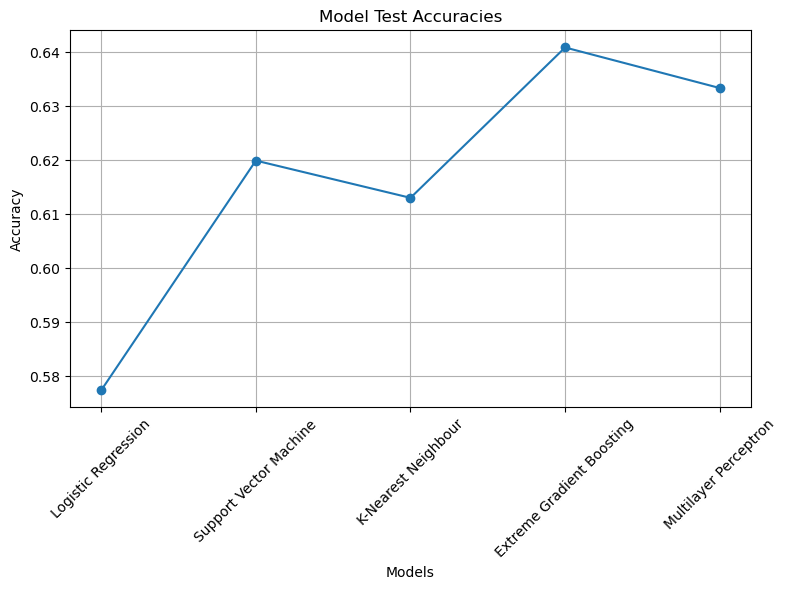

In [20]:
models = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbour', 'Extreme Gradient Boosting','Multilayer Perceptron']
accuracies = [test_acc_LR, test_acc_SVM ,test_acc_KNN, test_acc_XGB, test_acc_MLP]  # Example accuracies, replace with your actual data

plt.figure(figsize=(8, 6))
plt.plot(models, accuracies, marker='o')

plt.title('Model Test Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent cropping of labels
plt.show()

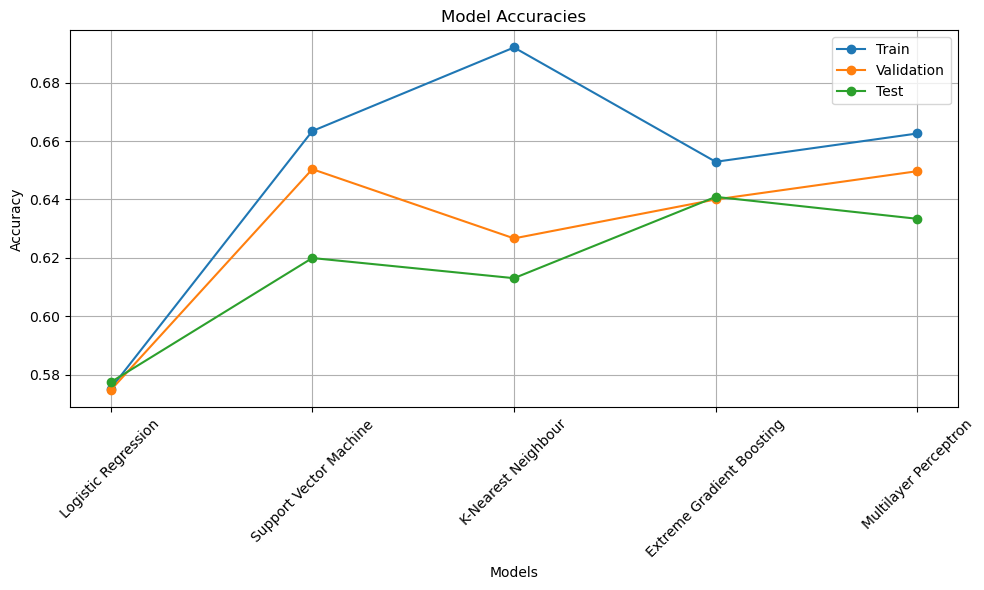

In [21]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbour', 'Extreme Gradient Boosting', 'Multilayer Perceptron']

train_accuracies = [train_acc_LR, train_acc_SVM, train_acc_KNN, train_acc_XGB, train_acc_MLP]
validation_accuracies = [validation_acc_LR, validation_acc_SVM, validation_acc_KNN, validation_acc_XGB, validation_acc_MLP]
test_accuracies = [test_acc_LR, test_acc_SVM, test_acc_KNN, test_acc_XGB, test_acc_MLP]
f1_scores = [f1_LR,f1_SVM,f1_KNN,f1_XGB,f1_MLP]

plt.figure(figsize=(10, 6))

# Plot train accuracies
plt.plot(models, train_accuracies, marker='o', label='Train')

# Plot validation accuracies
plt.plot(models, validation_accuracies, marker='o', label='Validation')

# Plot test accuracies
plt.plot(models, test_accuracies, marker='o', label='Test')

plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout to prevent cropping of labels
plt.show()


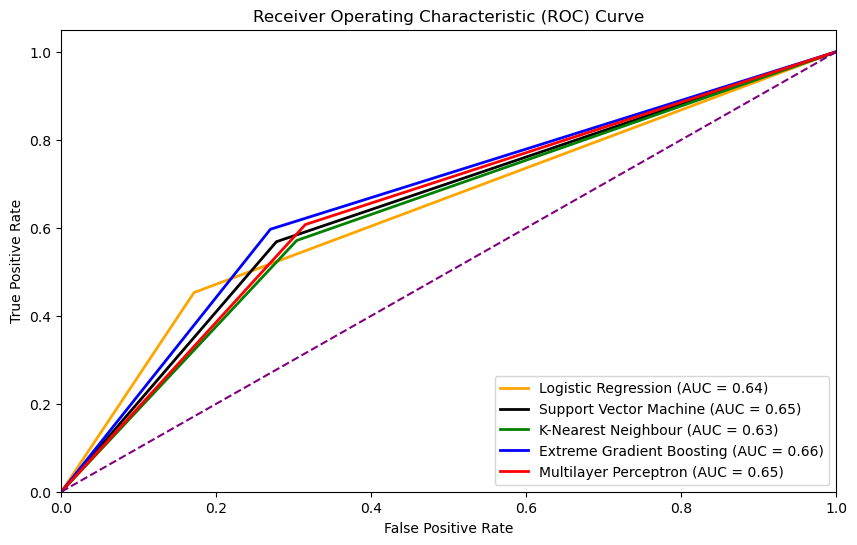

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_LR, tpr_LR, color='orange', lw=2, label=f'Logistic Regression (AUC = {auc_LR:.2f})')
plt.plot(fpr_SVM, tpr_SVM, color='black', lw=2, label=f'Support Vector Machine (AUC = {auc_SVM:.2f})')
plt.plot(fpr_KNN, tpr_KNN, color='green', lw=2, label=f'K-Nearest Neighbour (AUC = {auc_KNN:.2f})')
plt.plot(fpr_XGB, tpr_XGB, color='blue', lw=2, label=f'Extreme Gradient Boosting (AUC = {auc_XGB:.2f})')
plt.plot(fpr_MLP, tpr_MLP, color='red', lw=2, label=f'Multilayer Perceptron (AUC = {auc_MLP:.2f})')
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
roc_auc_scores = [auc_LR,auc_SVM,auc_KNN,auc_XGB,auc_MLP]
df_table = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': validation_accuracies,
    'Test Accuracy': test_accuracies,
    'ROC-AUC Score': roc_auc_scores, 
     'F1-Score': f1_scores
})

# Print the DataFrame
df_table

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,ROC-AUC Score,F1-Score
0,Logistic Regression,0.575216,0.574663,0.577426,0.640791,0.581063
1,Support Vector Machine,0.663406,0.650363,0.619942,0.645385,0.630119
2,K-Nearest Neighbour,0.692018,0.626665,0.613047,0.633693,0.623644
3,Extreme Gradient Boosting,0.652886,0.639993,0.640878,0.663424,0.651274
4,Multilayer Perceptron,0.662579,0.649674,0.633370,0.646228,0.643601
